In [338]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#!/usr/bin/env python3
from bs4 import BeautifulSoup
import re

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [339]:
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,hints,totalAccepted,totalSubmission,acRate
0,2369,maximum sum score array,maximum sum score array,Medium,3,3,"['Subarray Sum Equals K', 'Find Pivot Index', ...",Array,can use precalcul effici calcul averag differ ...,121,180,67.2
1,2354,minimum health beat game,minimum health beat game,Medium,18,5,"['Dungeon Game', 'Eliminate Maximum Number of ...",Array Greedy Prefix Sum,should use armor abil alway optim use armor ab...,562,870,64.6
2,2322,number way build sturdi brick wall,number way build sturdi brick wall,Medium,35,12,"['Brick Wall', 'Bricks Falling When Hit']",Array Dynamic Programming Bit Manipulation Bit...,row brick can repres uniqu point two brick joi...,704,1200,59.0
3,2321,minimum weight subgraph with requir path,given integ denot number node weight direct gr...,Hard,349,11,['Minimum Cost to Make at Least One Valid Path...,Graph Shortest Path,consid path src1 dest src2 dest would look lik...,5500,15700,34.9
4,2320,find all k-distant indic array,given index integ array num two integ key dist...,Easy,157,25,"['Two Sum', 'Shortest Word Distance']",Array,everi occurr key num find indic within distanc...,19900,30800,64.5


In [340]:
df.isnull().sum()

question_id          0
title                0
content              0
difficulty           0
likes                0
dislikes             0
similar_questions    0
topic_tags           0
hints                0
totalAccepted        0
totalSubmission      0
acRate               0
dtype: int64

In [341]:
#since the dataset is limited hence instead of using all the tags I will filter only the most important tags and train model on it
#check the number of topic tags and the data coverage

In [342]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(df['topic_tags'])

In [343]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [344]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df.shape[0]
for i in range(0, total_tags, 5):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

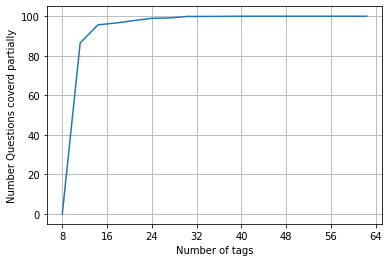

with  24 tags we are covering  99.154 % of questions


In [345]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(0+np.array(range(0,89,2))*4)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",24,"tags we are covering ",questions_explained[6],"% of questions")

In [346]:
multilabel_yx = tags_to_choose(24)
print("number of questions that are not covered :", questions_explained_fn(24),"out of ", total_qs)

number of questions that are not covered : 31 out of  2009


In [347]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 89
number of tags taken : 24 ( 26.96629213483146 %)


In [348]:
#split the data into train and test 
total_size=df.shape[0]
#performing a 90:10 split
train_size=int(0.90*total_size)

x_train=df.head(train_size)
x_test=df.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

<h3> one hot encoding </h3>

In [349]:
#one hot encoding the categorical feature- difficulty
vectorizer = CountVectorizer()
vectorizer.fit(x_train['difficulty'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_difficulty = vectorizer.transform(x_train['difficulty'].values)
x_test_difficulty = vectorizer.transform(x_test['difficulty'].values)

<h3> MinMax Scaler </h3>

In [350]:
#standardising the numerical values using MinMax scaler
from sklearn.preprocessing import MinMaxScaler
#standardising likes
scaler = MinMaxScaler()
scaler.fit(x_train['likes'].values.reshape(-1, 1))
x_train_likes = scaler.transform(x_train['likes'].values.reshape(-1, 1))
x_test_likes = scaler.transform(x_test['likes'].values.reshape(-1, 1))

#standardising dislikes
scaler = MinMaxScaler()
scaler.fit(x_train['dislikes'].values.reshape(-1, 1))
x_train_dislikes = scaler.transform(x_train['dislikes'].values.reshape(-1, 1))
x_test_dislikes = scaler.transform(x_test['dislikes'].values.reshape(-1, 1))

#standardising totalAccepted
scaler = MinMaxScaler()
scaler.fit(x_train['totalAccepted'].values.reshape(-1, 1))
x_train_accepted = scaler.transform(x_train['totalAccepted'].values.reshape(-1, 1))
x_test_accepted = scaler.transform(x_test['totalAccepted'].values.reshape(-1, 1))

#standardising totalSubmission
scaler = MinMaxScaler()
scaler.fit(x_train['totalSubmission'].values.reshape(-1, 1))
x_train_submission = scaler.transform(x_train['totalSubmission'].values.reshape(-1, 1))
x_test_submission = scaler.transform(x_test['totalSubmission'].values.reshape(-1, 1))

#standardising acRate
scaler = MinMaxScaler()
scaler.fit(x_train['acRate'].values.reshape(-1, 1))
x_train_acRate = scaler.transform(x_train['acRate'].values.reshape(-1, 1))
x_test_acRate = scaler.transform(x_test['acRate'].values.reshape(-1, 1))

In [351]:
x_train.drop('similar_questions', axis=1, inplace=True)
x_test.drop('similar_questions', axis=1, inplace=True)

In [352]:
from datetime import datetime
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=995, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))

x_train_tfidf = vectorizer.fit_transform(x_train['hints']+x_train['title']+x_train['content'])
x_test_tfidf = vectorizer.transform(x_test['hints']+x_test['title'] + x_test['content'] )
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.513692


In [353]:
from scipy.sparse import hstack
X_tr = hstack((x_train_tfidf, x_train_likes, x_train_dislikes, x_train_accepted, x_train_submission, x_train_acRate)).tocsr()
X_te = hstack((x_test_tfidf, x_test_likes, x_test_dislikes, x_test_accepted, x_test_submission, x_test_acRate)).tocsr()
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

(1808, 1000) (1808, 24)
(201, 1000) (201, 24)


<h3>Applying Logistic Regression with OneVsRest Classifier </h3>

In [354]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(X_tr, y_train)
predictions = classifier.predict(X_te)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 score :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.1791044776119403
macro f1 score : 0.5499784737855112
micro f1 score : 0.6340668296658517
hamming loss : 0.09307628524046435
Precision recall report :
               precision    recall  f1-score   support

           0       0.89      0.86      0.87        83
           1       0.92      0.87      0.90        54
           2       0.48      0.91      0.63        47
           3       0.48      0.31      0.38        35
           4       0.44      0.35      0.39        34
           5       0.67      0.32      0.44        37
           6       0.70      0.38      0.49        37
           7       0.75      0.46      0.57        26
           8       0.76      0.85      0.80        41
           9       0.57      0.84      0.68        25
          10       0.40      0.57      0.47        14
          11       0.00      0.00      0.00         8
          12       0.97      0.97      0.97        29
          13       0.43      0.72      0.54        18
          14       1.00  

In [331]:
#for finding similar question I will create a tfidf vectorizer on titles only
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=500, ngram_range=(1,3))
X = vectorizer.fit_transform(x_train['title'])
X.shape

(1808, 500)

In [332]:
#take a query from test data 
print(x_test['title'].iloc[5])
transformed_title = vectorizer.transform([x_test['title'].iloc[0]])

word search two


In [333]:
#finding similarity of the test query with all the sentences in the train data
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
results = cosine_similarity(X, transformed_title).reshape((-1,))

#get top 2 most similar questions
for i in results.argsort()[-2:][::-1]:
    print('question ID: {} -- similar_question is {}-- Similarity score:{}'.format(x_train.iloc[i,0], x_train.iloc[i,1],results[i]))

question ID: 219 -- similar_question is contain duplic two-- Similarity score:0.92323199747196
question ID: 220 -- similar_question is contain duplic three-- Similarity score:0.8759523298599456


<h3> 4.5.3 Applying SVM with OneVsRest Classifier </h3>

In [358]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(X_tr, y_train)
predictions = classifier.predict(X_te)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.13930348258706468
macro f1 score : 0.530513724196972
micro f1 scoore : 0.615737203972498
hamming loss : 0.10427031509121061
Precision recall report :
               precision    recall  f1-score   support

           0       0.87      0.89      0.88        83
           1       0.89      0.91      0.90        54
           2       0.46      0.91      0.61        47
           3       0.34      0.34      0.34        35
           4       0.33      0.29      0.31        34
           5       0.62      0.41      0.49        37
           6       0.65      0.41      0.50        37
           7       0.75      0.46      0.57        26
           8       0.75      0.88      0.81        41
           9       0.55      0.92      0.69        25
          10       0.35      0.57      0.43        14
          11       0.20      0.12      0.15         8
          12       0.97      0.97      0.97        29
          13       0.32      0.67      0.43        18
          14       1.00  